In [14]:
import os
import math
import numpy as np
import random
import matplotlib.pyplot as plt

import torch

from safetensors.torch import save_file, load_file

random.seed(33)

In [15]:
file_path = "model_weights/corrupted_positions.safetensors"
positions = load_file(file_path)["positions"].int().tolist()
positions = sorted(positions)

file_path = "model_weights/model_pretrained.safetensors"
# Load the model state dictionary
state_dict_pretrained = load_file(file_path)

# Define the path to the saved model
file_path = "model_weights/model_corrupted.safetensors"
state_dict_finetuned = load_file(file_path)

In [16]:
gradient_weights = state_dict_pretrained['fc1.weight'][positions,:] - state_dict_finetuned['fc1.weight'][positions,:]
gradient_bias = state_dict_pretrained['fc1.bias'][positions] - state_dict_finetuned['fc1.bias'][positions]
gradient_bias_expanded = gradient_bias.unsqueeze(1)
print("Number of activated neurons:", (gradient_weights != 0).any(dim=1).nonzero(as_tuple=True)[0].size()[0])

Number of activated neurons: 85


In [17]:
recovered_images = torch.div(gradient_weights, gradient_bias_expanded)
images_28x28 = recovered_images.view(-1, 28, 28)

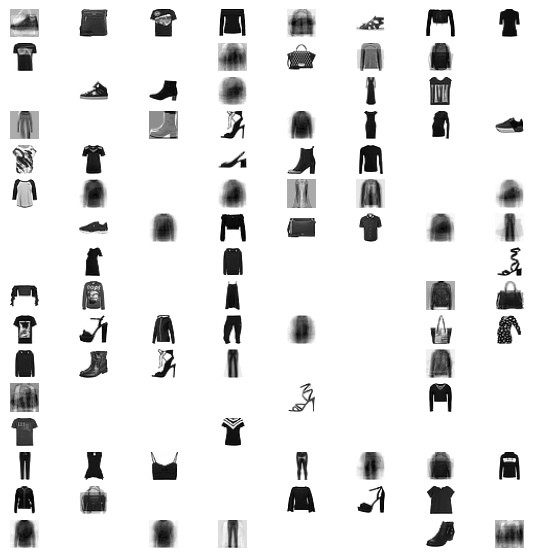

In [18]:
num_images = images_28x28.size(0)
num_cols = 8 
num_rows = math.ceil(num_images / num_cols) 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 7))
axes = axes.flatten() 

for i in range(num_images):
    axes[i].imshow(images_28x28[i].squeeze(), cmap=plt.cm.binary) 
    axes[i].axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.show()

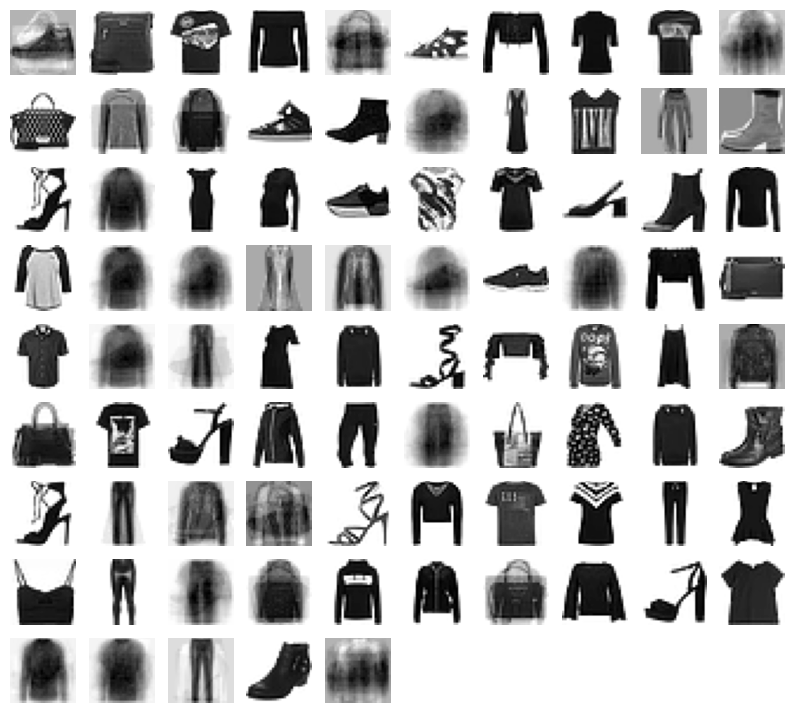

In [34]:
# show only clear images
threshold = 0.5
clear_images = [img for img in recovered_images if img.abs().max() > threshold]

num_clear = len(clear_images)
num_cols = 10
num_rows = math.ceil(num_clear / num_cols)

plt.figure(figsize=(num_cols, num_rows)) # expand figure size by multiply rows, cols with 2 for example
for i, img in enumerate(clear_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img.reshape(28,28), cmap='binary')
    plt.axis('off')
plt.show()